In [82]:
import glob
from default_params import default_params
import skimage.io
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import os.path
import skimage.io
import time
import json
import multiprocessing

import skimage.io
from Panos.Pano_rectification import simon_rectification
from Panos.Pano_project import project_face, stitch_tiles, render_imgs
import matplotlib.pyplot as plt

from Panos.Pano_visualization import R_heading, draw_all_vp_and_hl_color, draw_all_vp_and_hl_bi, \
    draw_zenith_on_top_color, draw_zenith_on_top_bi, draw_sphere_zenith, R_roll, R_pitch
from Panos.Pano_zp_hvp import calculate_consensus_zp
from Panos.Pano_consensus_vis import draw_consensus_zp_hvps, draw_consensus_rectified_sphere, \
    draw_center_hvps_rectified_sphere, draw_center_hvps_on_panorams
import Pano_hvp
from Panos.Pano_histogram import calculate_histogram
from Panos.Pano_project import project_facade_for_refine

In [83]:
plot_redundant = False
save_directly = False

root = 'Pano_new_FB'

Country_city = 'New'

new_count = 5

tmp_count = str(new_count)

inter_Dir = os.path.join(root, 'Pano_hl_z_vp/')

"""
Img_folder = os.path.join(root, Country_city, 'images/')


imageList = glob.glob(Img_folder + '*.jpg')
imageList.sort()
"""

import geopandas as gpd

geojson_path = '../../data/Street_view/Preprocessed_to_use_for_picture_extraction.geojson'
gdf_combined = gpd.read_file(geojson_path)
gdf_combined = gdf_combined.iloc[:5,:] # ONLY FIRST 5 LINES

images_base_folder = '../../data/PANO_new/'

paths = gdf_combined['PATH'].values.tolist()
runs = gdf_combined['RUN'].values.tolist()
photos = gdf_combined['FOTO'].values.tolist()

imageList = []
for i in range(len(paths)):
    path_val = paths[i]
    run_val = runs[i]
    foto_val = photos[i]
    image_path = os.path.join(images_base_folder, str(path_val), str(run_val), str(foto_val))
    imageList.append(image_path)

rendering_output_folder = os.path.join(root, Country_city, 'Rendering')
if not os.path.exists(rendering_output_folder):
    os.makedirs(rendering_output_folder)

In [84]:
for im_path in imageList:
    print(im_path)
    im = Image.open(im_path)
    rendering_img_base = os.path.join(rendering_output_folder, os.path.splitext(os.path.basename(im_path))[0])

    task = 'hahaha/'
    thread_num = 1
    thread = str(thread_num) + '/'
    tmp_folder = os.path.join(root, Country_city, 'tmp', task, thread)
    tmp_folder_ifab = os.path.join(root, Country_city, 'tmp_ifab', task, thread)

    if not os.path.exists(tmp_folder):
        os.makedirs(tmp_folder)
    if not os.path.exists(tmp_folder_ifab):
        os.makedirs(tmp_folder_ifab)
    removelist = glob.glob(tmp_folder + '*.jpg')
    for i in removelist:
        os.remove(i)

    #render_num = 16
    render_num = 4
    start = int(-render_num / 2) + 1
    end = render_num + start
    degree = 360 / render_num
    panorama_img = skimage.io.imread(im_path)
    coordinates_list = []


    tilelist = render_imgs(panorama_img, tmp_folder, tmp_folder_ifab, save_directly)
    if not save_directly:
        tilelist = glob.glob(tmp_folder + '*.jpg')
        tilelist.sort()

    hl = []
    hvps = []
    hvp_groups = []
    z = []
    z_group = []
    ls = []
    z_homo = []
    hvp_homo = []
    ls_homo = []

    for i in range(len(tilelist)):
        [tmp_hl, tmp_hvps, tmp_hvp_groups, tmp_z, tmp_z_group, tmp_ls, tmp_z_homo, tmp_hvp_homo, tmp_ls_homo, params] = simon_rectification(tilelist[i], i, inter_Dir, root, new_count)
        hl.append(tmp_hl)
        hvps.append(tmp_hvps)
        hvp_groups.append(tmp_hvp_groups)
        z.append(tmp_z)
        z_group.append(tmp_z_group)
        ls.append(tmp_ls)
        z_homo.append(tmp_z_homo)
        hvp_homo.append(tmp_hvp_homo)
        ls_homo.append(tmp_ls_homo)

    removelist = glob.glob(tmp_folder + '*.jpg')
    for i in removelist:
        os.remove(i)

    ####################### Get all the zenith points from all the (8) viewpoints

    zenith_points = np.array([R_heading(np.pi / 2 * (i - 1)).dot(zenith) for i, zenith in enumerate(z_homo)])
    points2 = np.array([R_heading(np.pi / 2 * (i - 1)).dot(np.array([0., 0., 1.])) for i in range(len(z_homo))])
    hv_points = [(R_heading(np.pi / 2 * (i - 1)).dot(hv_p.T)).T for i, hv_p in enumerate(hvp_homo)]

    if plot_redundant:
        draw_all_vp_and_hl_color(zenith_points, hv_points, im.copy(), root)
        draw_all_vp_and_hl_bi(zenith_points, hv_points, im.copy(), root)
        draw_sphere_zenith(zenith_points, hv_points, root)

    ####################### Calculate the consensus zenith point

    [zenith_consensus, best_zenith] = calculate_consensus_zp(zenith_points, method='svd')

    # Transform the zenith points back to original homogeneous coordinates
    zenith_consensus_org = np.array([R_heading(-np.pi / 2 * (i - 1)).dot(zenith) for i, zenith in enumerate(zenith_consensus)])

    result_list = []
    for i in range(len(zenith_consensus_org)):

        #result = Pano_hvp.hvp_from_zenith(ls_homo[i], zenith_consensus_org[i], params)

        result = Pano_hvp.get_all_hvps(ls_homo[i], zenith_consensus_org[i], params)
        result_list.append(result)

    hvps_consensus_org = []
    for i in range(len(result_list)):
        # hvps_consensus_org.append(result_list[i]['hvp_homo'])
        hvps_consensus_org.append(result_list[i])

    hvps_consensus_uni = [(R_heading(np.pi / 2 * (i - 1)).dot(hv_p.T)).T for i, hv_p in enumerate(hvps_consensus_org)]

    if plot_redundant:
        draw_consensus_zp_hvps(best_zenith, hvps_consensus_uni, im.copy(), root)

    ####################### Calculate pitch and roll
    pitch = np.arctan(best_zenith[2] / best_zenith[1])
    roll = - np.arctan(best_zenith[0] / np.sign(best_zenith[1]) * np.hypot(best_zenith[1], best_zenith[2]))

    hvps_consensus_rectified = [R_roll(-roll).dot(R_pitch(-pitch).dot(vp.T)).T for vp in hvps_consensus_uni]

    if plot_redundant:
        draw_consensus_rectified_sphere(hvps_consensus_rectified, root)

    ###################### Calculate horizontal VP histogram

    final_hvps_rectified = calculate_histogram(hvps_consensus_rectified, root, plot_redundant)

    if plot_redundant:
        draw_center_hvps_rectified_sphere(np.array(final_hvps_rectified), root)
        draw_center_hvps_on_panorams(best_zenith, np.array(final_hvps_rectified), im.copy(), pitch, roll, root)

    ###################### Rendering images from panoramas

    print(f"Horizontal VPs: {np.array(final_hvps_rectified)}")
    print(f"Pitch: {pitch}, Roll: {roll}")
    print(f"Temp count: {tmp_count}")
    project_facade_for_refine(np.array(final_hvps_rectified), im.copy(), pitch, roll, im_path, root, tmp_folder, rendering_img_base, tmp_count)
    print(100)

../../data/PANO_new/B\117\pano_000117_000042.jpg


d:\OneDrive - Net Service S.p.A\Documents\Github\hammon-WP4\lsaa-dataset-master\Panorama_Rectification\vp_predict.py:54: RuntimeWarning: invalid value encountered in sqrt
  d2 = np.sqrt(rho2 * rho2 - 1)
d:\OneDrive - Net Service S.p.A\Documents\Github\hammon-WP4\lsaa-dataset-master\Panorama_Rectification\z_predict.py:20: RuntimeWarning: divide by zero encountered in divide
  lines_tilt_ortho = np.arctan(-lines_homo[1,:] / lines_homo[0,:])*180 / np.pi


Horizontal VPs: [[8.65269686e-03 2.44093999e-07 9.99962565e-01]
 [9.16710059e-01 2.58605412e-05 3.99553085e-01]]
Pitch: 0.017342155810624444, Roll: 0.030422867117432764
Temp count: 5
100
../../data/PANO_new/B\117\pano_000117_000043.jpg
Horizontal VPs: [[7.56305849e-03 5.67924400e-07 9.99971400e-01]]
Pitch: 0.020672292939604684, Roll: 0.04213878594461021
Temp count: 5
100
../../data/PANO_new/B\117\pano_000117_000045.jpg
Horizontal VPs: [[ 6.09161229e-03  1.18237610e-07 -9.99981446e-01]]
Pitch: 0.023702942575051785, Roll: 0.026861605293504197
Temp count: 5
100
../../data/PANO_new/B\117\pano_000117_000047.jpg
Horizontal VPs: [[ 6.57540389e-03  1.08003232e-07 -9.99978382e-01]
 [ 3.20921531e-01  5.27124466e-06 -9.47105786e-01]]
Pitch: 0.018677806478619132, Roll: 0.02540880916712151
Temp count: 5
100
../../data/PANO_new/B\117\pano_000117_000049.jpg
Horizontal VPs: [[1.06326601e-02 2.77624761e-07 9.99943472e-01]]
Pitch: 0.01397159752663571, Roll: 0.02964948704405594
Temp count: 5
100


In [85]:
"""
calculate_yaw_rad.py
--------------------
Adds three new columns to the input GeoJSON and prints the first few rows.

• **midpoint_yaw_rad**   – yaw (radians) from the camera point (X, Y) to the
  facade midpoint.
• **edge_first_yaw_rad** – yaw to the *first* vertex of `geometry_outer_edge`.
• **edge_second_yaw_rad**– yaw to the *second* vertex (if it exists).

The script avoids lambda expressions for clarity and writes the enriched
GeoDataFrame back to disk (alongside the original) so you can load it
immediately in other notebooks.
"""

from __future__ import annotations

import math
from pathlib import Path
from typing import List, Tuple

import geopandas as gpd
from shapely.geometry import LineString, Point
from shapely import wkt

# ---------------------------------------------------------------------------
# Configuration – adjust to taste
# ---------------------------------------------------------------------------
INPUT_GEOJSON = Path("../../data/Street_view/Preprocessed_to_use_for_picture_extraction.geojson")
OUTPUT_GEOJSON = INPUT_GEOJSON.with_name(INPUT_GEOJSON.stem + "_with_yaw.geojson")

# ---------------------------------------------------------------------------
# Helper functions
# ---------------------------------------------------------------------------

def load_geojson(path: Path) -> gpd.GeoDataFrame:
    """Read a GeoJSON file and return a GeoDataFrame."""
    try:
        return gpd.read_file(path)
    except Exception as exc:
        raise SystemExit(f"❌  Unable to read GeoJSON → {exc}") from exc


def ensure_outer_edges(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """Ensure *geometry_outer_edge_shapely* contains Shapely LineStrings."""
    if "geometry_outer_edge_shapely" in gdf.columns:
        return gdf

    if "geometry_outer_edge" not in gdf.columns:
        raise ValueError("GeoJSON has no geometry_outer_edge column.")

    edges: List[LineString] = []
    for geom in gdf["geometry_outer_edge"]:
        if isinstance(geom, LineString):
            edges.append(geom)
        else:
            # Assume WKT string
            edges.append(wkt.loads(geom))
    gdf["geometry_outer_edge_shapely"] = edges
    return gdf


def ensure_midpoints(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """Create *geometry_midpoint* column if missing."""
    if "geometry_midpoint" in gdf.columns:
        return gdf

    if {"midpoint_x", "midpoint_y"}.issubset(gdf.columns):
        midpoints = [Point(xy) for xy in zip(gdf["midpoint_x"], gdf["midpoint_y"])]
        gdf["geometry_midpoint"] = midpoints
        return gdf

    # Fall back to centroid of the outer‑edge LineString
    gdf = ensure_outer_edges(gdf)
    gdf["geometry_midpoint"] = gdf["geometry_outer_edge_shapely"].centroid
    return gdf


def yaw_radians(cam_x: float, cam_y: float, tgt_x: float, tgt_y: float) -> float:
    """Azimuth (radians) from camera → target using atan2 convention."""
    return math.atan2(tgt_y - cam_y, tgt_x - cam_x)


def first_two_vertices(edge: LineString) -> Tuple[Point, Point | None]:
    """Return the first and second vertices as Points (second may be None)."""
    coords = list(edge.coords)
    first_pt = Point(coords[0])
    second_pt = Point(coords[1]) if len(coords) > 1 else None
    return first_pt, second_pt

# ---------------------------------------------------------------------------
# Main script
# ---------------------------------------------------------------------------


gdf = load_geojson(INPUT_GEOJSON)
gdf = ensure_outer_edges(gdf)
gdf = ensure_midpoints(gdf)

# Prepare containers for new columns
midpoint_yaws: List[float] = []
first_yaws: List[float] = []
second_yaws: List[float | None] = []

for idx, row in gdf.iterrows():
    cam_x: float = row["X"]
    cam_y: float = row["Y"]

    # Midpoint yaw
    midpoint: Point = row["geometry_midpoint"]
    midpoint_yaws.append(yaw_radians(cam_x, cam_y, midpoint.x, midpoint.y))

    # First + second vertices yaws
    edge: LineString = row["geometry_outer_edge_shapely"]
    v1, v2 = first_two_vertices(edge)
    first_yaws.append(yaw_radians(cam_x, cam_y, v1.x, v1.y))
    if v2 is not None:
        second_yaws.append(yaw_radians(cam_x, cam_y, v2.x, v2.y))
    else:
        second_yaws.append(None)

# Attach columns
gdf["midpoint_yaw_rad"] = midpoint_yaws
gdf["edge_first_yaw_rad"] = first_yaws
gdf["edge_second_yaw_rad"] = second_yaws

# Show a quick preview
print(gdf[["midpoint_yaw_rad", "edge_first_yaw_rad", "edge_second_yaw_rad"]].head())


   midpoint_yaw_rad  edge_first_yaw_rad  edge_second_yaw_rad
0          1.447189            0.802275             1.921502
1          1.623585            0.984224             1.995878
2          1.114931            0.389622             1.806627
3          1.185547            0.349948             1.923616
4          1.039363            0.618248             1.536991


    heading  i  j
0  1.566593  0  0
1  4.706547  0  1
2  0.413953  1  0
1.5699854220304348


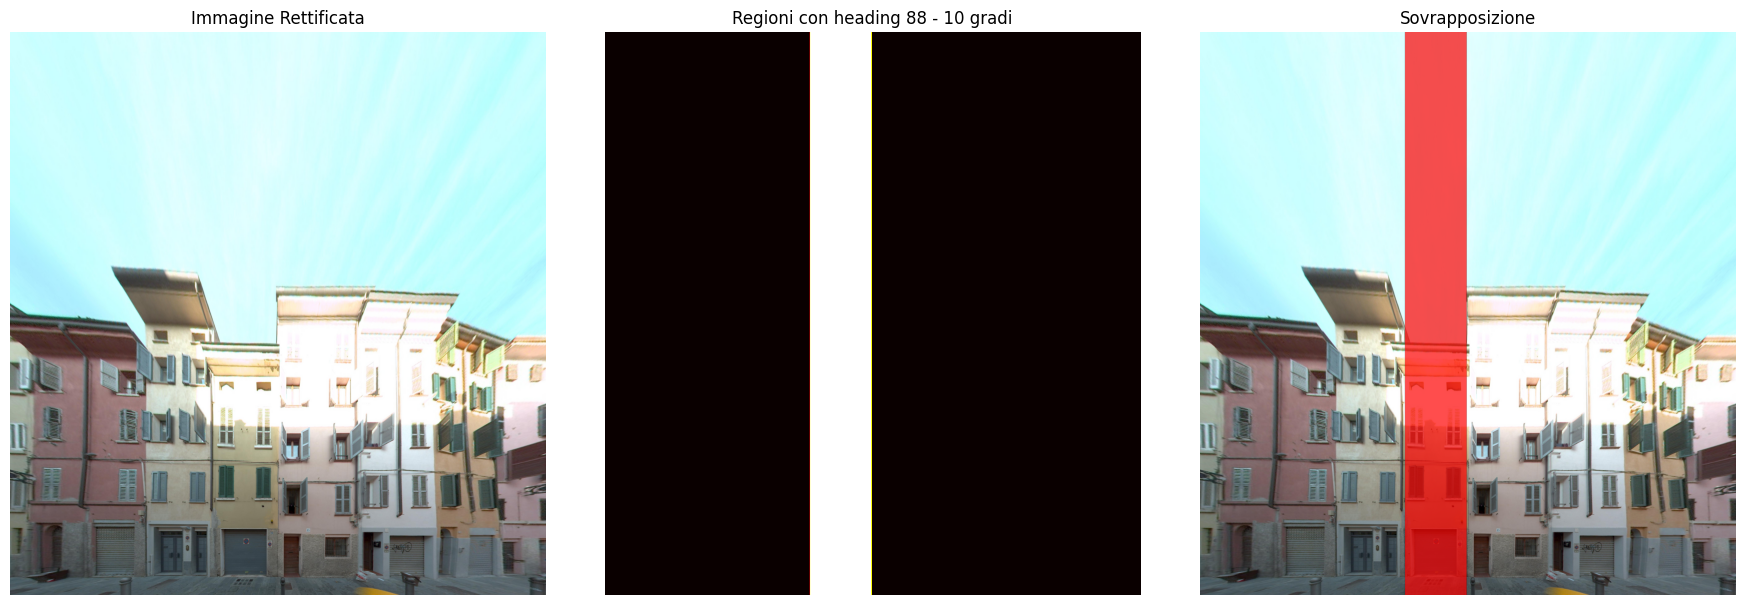

    heading  i  j
0  1.564623  0  0
1  4.705687  0  1
1.5698340064517957


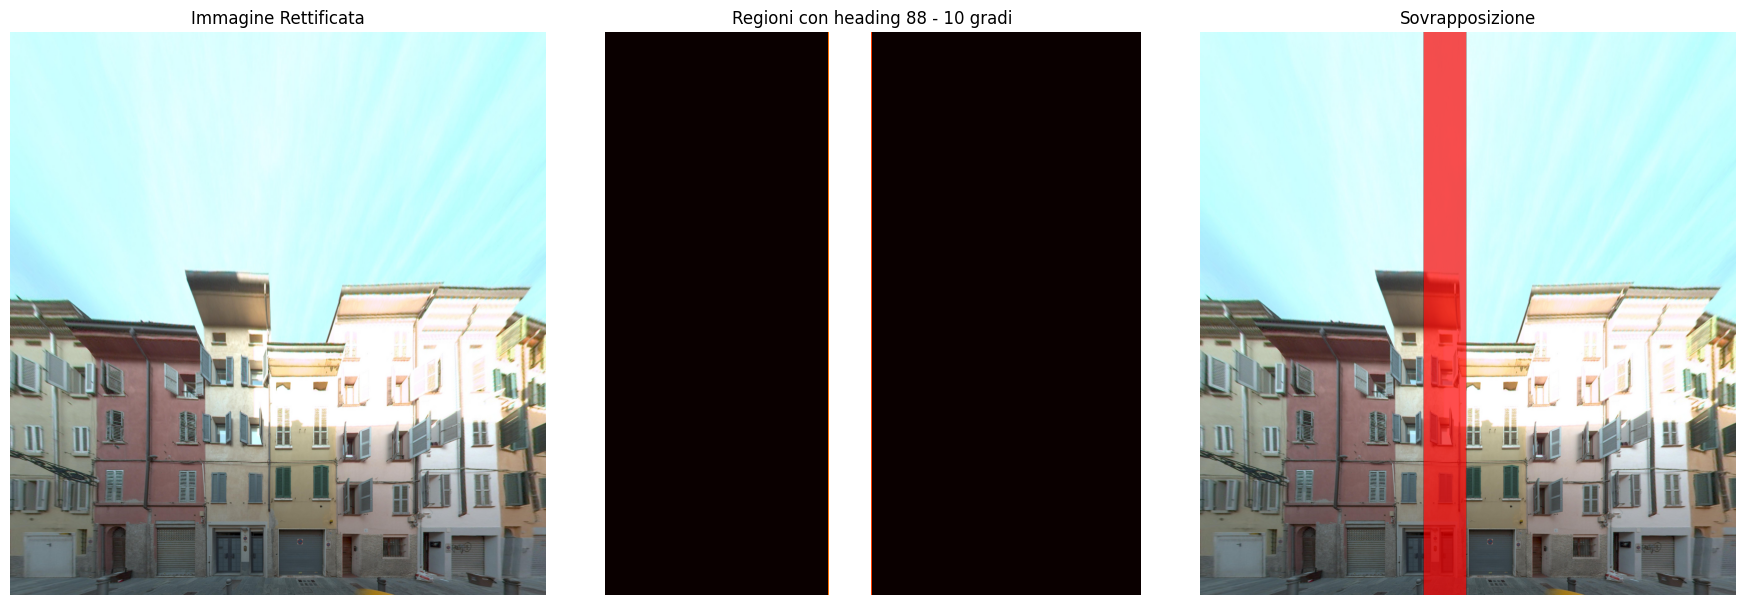

    heading  i  j
0 -1.569700  0  0
1  1.574522  0  1
1.5705746978128063


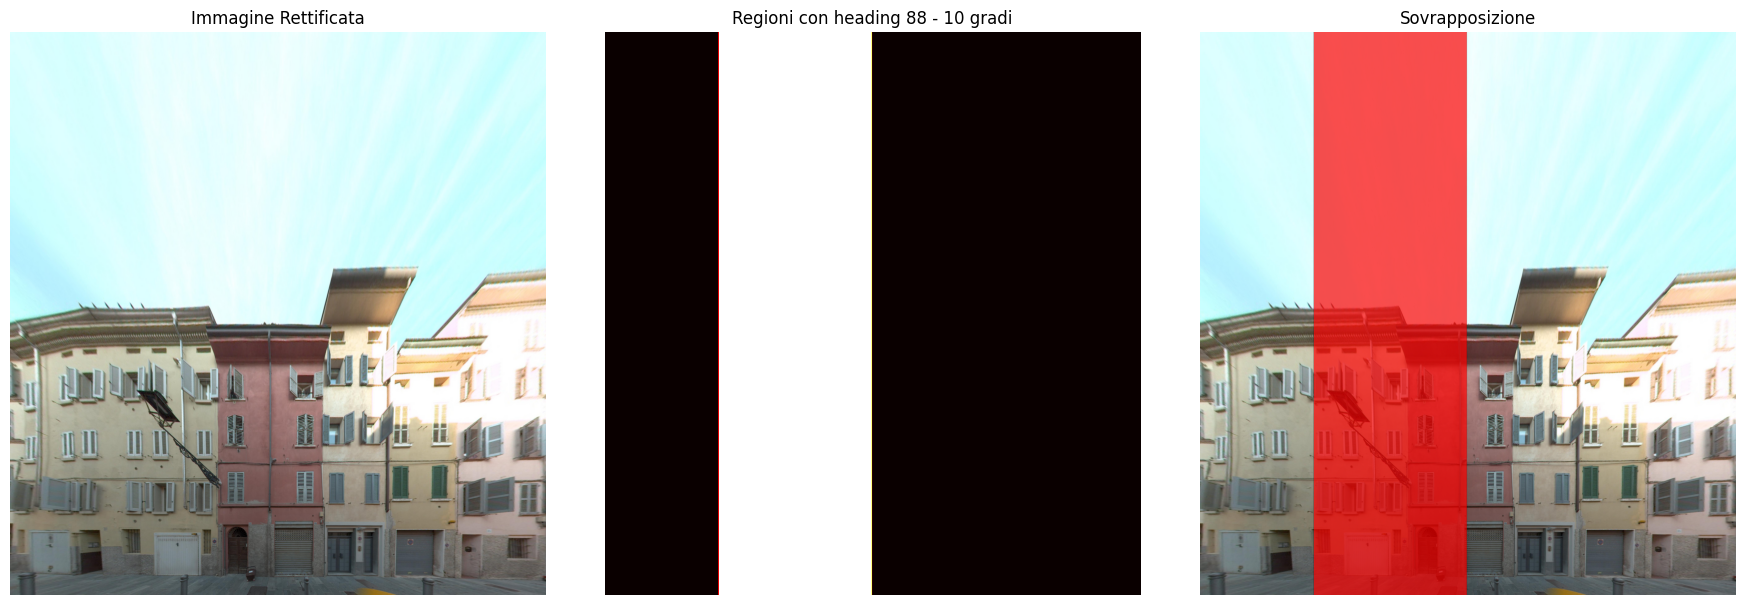

    heading  i  j
0 -1.568304  0  0
1  1.577506  0  1
1.570404088146722


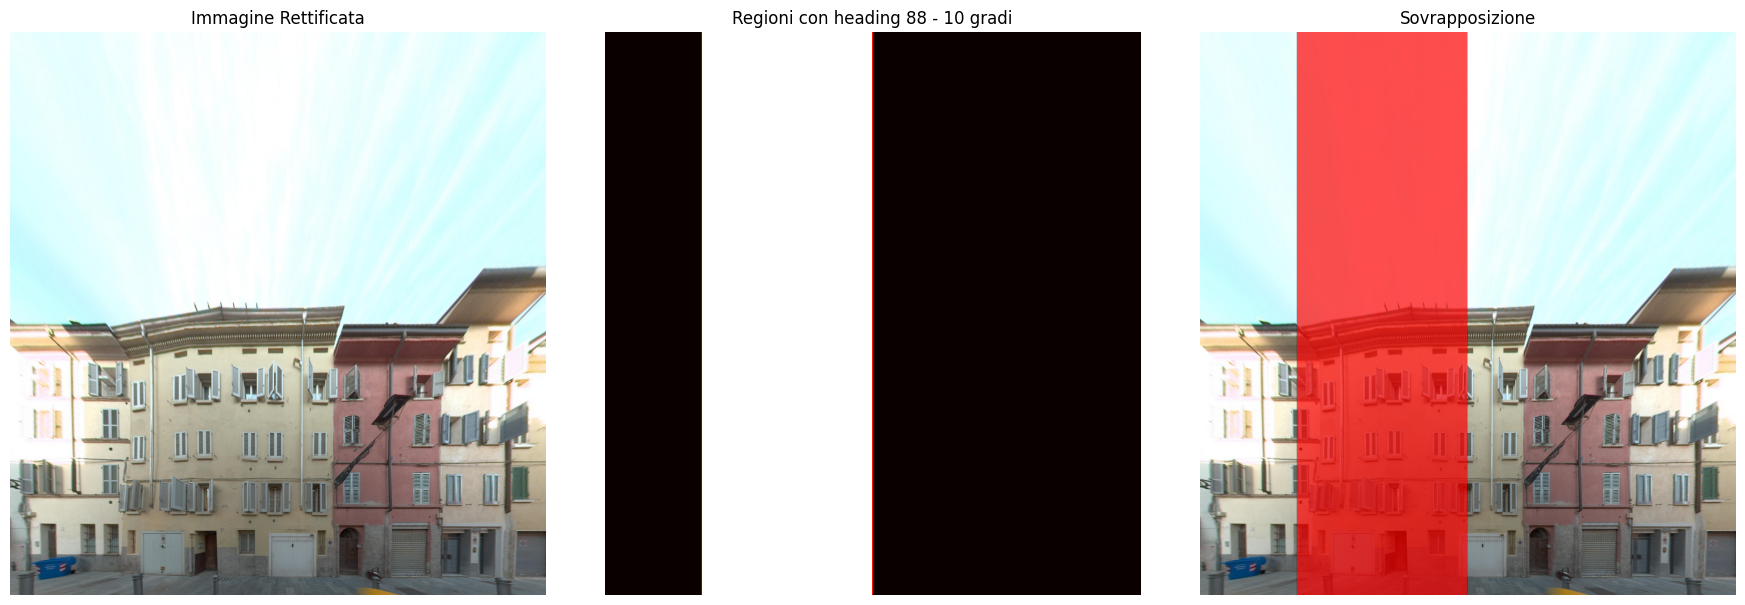

    heading  i  j
0  1.559251  0  0
1  4.702677  0  1
1.5692102079323422


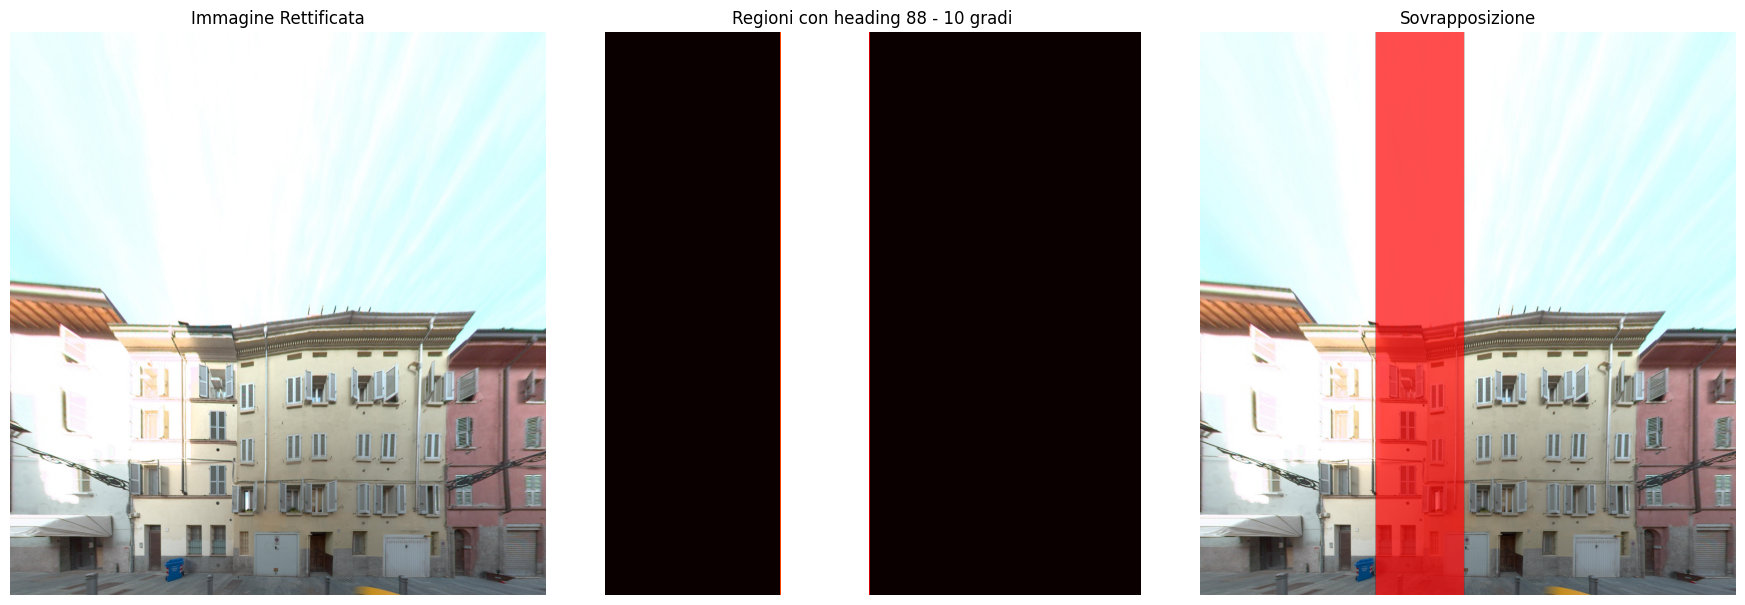

In [86]:
from matplotlib.colors import LinearSegmentedColormap

image_folder = r"D:\OneDrive - Net Service S.p.A\Documents\Github\hammon-WP4\lsaa-dataset-master\Panorama_Rectification\Pano_new_FB\New\Rendering"
gdf = gdf.iloc[:5,:] # ONLY FIRST 5 LINES
for row in gdf.iterrows():
    image_name = row[1]["FOTO"].split(".")[0]
    json_name = image_name +"_heading_facade.json"
    json = pd.read_json(os.path.join(image_folder, json_name))
    heading_midpoint = row[1]["midpoint_yaw_rad"]
    heading_diff = json["heading"] - heading_midpoint
    headin_index = np.argmin(np.abs(heading_diff))
    i = json["i"][headin_index]
    j = json["j"][headin_index]

    print(json)

    rectified_image_target_path = image_name +"_VP_"+str(i)+"_"+str(j)+".jpg"
    heading_map_target_path = image_name +"_VP_"+str(i)+"_"+str(j)+"_heading_map.npy"
    heading_first = row[1]["edge_first_yaw_rad"]
    heading_second = row[1]["edge_second_yaw_rad"]

    rectified_image_target = Image.open(os.path.join(image_folder, rectified_image_target_path))
    heading_map_target  = np.load(os.path.join(image_folder, heading_map_target_path), allow_pickle=True)

    mask_greater = heading_map_target > np.pi/2
    mask_lesser = heading_map_target < -np.pi/2
    
    heading_map_target[mask_greater] -= np.pi
    heading_map_target[mask_lesser] += np.pi

    heading_map_target_row_mutiple = heading_map_target[-1,:]
    heading_map_target_multiple = np.tile(heading_map_target_row_mutiple, (heading_map_target.shape[0],1))

    print(heading_map_target_multiple.max())

    # create maks where values al in between the two yaws
    mask = np.logical_and(heading_map_target > heading_first, heading_map_target < heading_second)
    heading_map_target[mask] = 0 

    mask = np.logical_and(heading_map_target_multiple > heading_first, heading_map_target_multiple < heading_second)
    heading_map_target_multiple[mask] = 0 

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(rectified_image_target)
    axes[0].set_title("Immagine Rettificata")
    axes[0].axis('off')

    axes[1].imshow(mask, cmap='hot')
    axes[1].set_title(f"Regioni con heading 88 - 10 gradi")
    axes[1].axis('off') 


    colors = [(0, 0, 0, 0), (1, 0, 0, 0.7)]  # Da trasparente a rosso semi-trasparente
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

    # Visualizza l'immagine originale
    axes[2].imshow(rectified_image_target)
    # Sovrapponi la maschera con la mappa colore personalizzata
    axes[2].imshow(mask, cmap=cmap)
    axes[2].set_title("Sovrapposizione")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()
